In [2]:
import json
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

### [IGNORE] Experiment with TEN creation

In [19]:
def create_separate_tens(height, width, num_timesteps, data_movements):
    graphs = []
    positions = []
    
    # Create independent graphs for each timestep
    for t in range(num_timesteps):
        G = nx.DiGraph()
        pos = {}
        
        # Add nodes and their positions for the current timestep
        for i in range(height):
            for j in range(width):
                node_id = (i, j)
                G.add_node(node_id)
                pos[node_id] = (j, height - i)  # Regular grid positioning

        # Add edges based on chunk movements for the current timestep
        if t < num_timesteps - 1:
            for i in range(height):
                for j in range(width):
                    for (di, dj) in data_movements:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < height and 0 <= nj < width:
                            G.add_edge((i, j), (ni, nj))

        graphs.append(G)
        positions.append(pos)
    
    return graphs, positions

def draw_separate_tens(graphs, positions, width_per_graph=5):
    fig, axes = plt.subplots(1, len(graphs), figsize=(width_per_graph * len(graphs), width_per_graph))
    if len(graphs) == 1:
        axes = [axes]  # ensure axes are iterable
    
    for ax, (G, pos) in zip(axes, zip(graphs, positions)):
        nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', ax=ax, arrowsize=20, font_size=9)
        ax.set_title(f"Graph at timestep {positions.index(pos)}")

    plt.show()



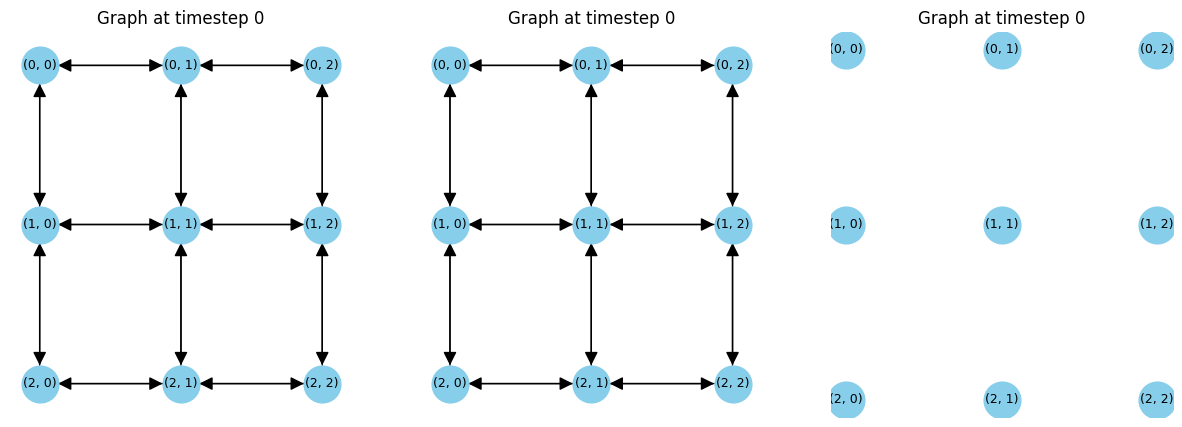

In [20]:
# Example usage
height = 3
width = 3
num_timesteps = 3
data_movements = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Directions: right, down, left, up

graphs, positions = create_separate_tens(height, width, num_timesteps, data_movements)
draw_separate_tens(graphs, positions)

###  [IGNORE] Preprocess TACOS output

In [21]:
import csv

def preprocess_csv(input_file, output_file):
    timestep_mapping = {}
    current_timestep = 0
    
    with open(input_file, 'r') as file:
        csv_reader = csv.reader(file)
        rows = list(csv_reader)
    
    with open(output_file, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        
        for row in rows:
            timestep = float(row[0])
            
            if timestep not in timestep_mapping:
                timestep_mapping[timestep] = current_timestep
                current_timestep += 1
            
            row[0] = str(timestep_mapping[timestep])
            csv_writer.writerow(row)

# input and output CSV file paths
input_file = 'build/bin/output.csv'
output_file = 'preprocessed_output.csv'

# Preprocess the CSV file
preprocess_csv(input_file, output_file)
print(f"Preprocessed CSV file created: {output_file}")

Preprocessed CSV file created: preprocessed_output.csv


### [IGNORE] Process the cleaned data into graph timesteps

In [22]:
# load the CSV file
col_Names=["Timestep", "chunkID", "source", "destination"]
df = pd.read_csv('preprocessed_output.csv', sep='\t', names=col_Names, header=None)

# Get unique timesteps
timesteps = df['Timestep'].unique()

# Initialize a list to hold the graph for each timestep
graphs = []

for timestep in timesteps:
    # Filter rows belonging to the current timestep
    timestep_data = df[df['Timestep'] == timestep]
    
    # Create a directed graph for the current timestep
    G = nx.DiGraph()
    
    # Add edges to the graph
    for _, row in timestep_data.iterrows():
        source = row['source']
        destination = row['destination']
        chunkID = row['chunkID']
        G.add_edge(source, destination, chunkID=chunkID)
    
    graphs.append(G)

# Function to draw each graph
def draw_graphs(graphs):
    # Determine the number of rows needed to plot all graphs comfortably
    n_rows = len(graphs) // (3 + 1) if len(graphs) % 3 > 0 else len(graphs) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for i, G in enumerate(graphs):
        ax = axes[i]
        pos = nx.spring_layout(G)  # Position nodes using the spring layout
        labels = nx.get_edge_attributes(G, 'chunkID')
        nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', ax=ax, arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
        ax.set_title(f"Timestep {i}")
        
    # Hide any unused subplot areas
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
# Commented out the drawing of the graphs
# draw_graphs(graphs)


### [IGNORE] Include all Nodes in 2D mesh regardless of inbound/outbound connections

In [24]:
# Load the CSV file
df = pd.read_csv('preprocessed_output.csv')
print(df.head)

# Assuming height and width of the mesh are known
height = 3  # Adjust as necessary based on mesh structure
width = 3   # Adjust as necessary based on mesh structure

def add_all_nodes(G, height, width):
    for i in range(height * width):  # Assuming node identifiers are from 0 to height*width-1
        G.add_node(i)

# Get unique timesteps
timesteps = df['Timestep'].unique()

graphs = []

for timestep in timesteps:
    timestep_data = df[df['Timestep'] == timestep] # slice the dataframes into t = 0, 1...N
    print(timestep_data.head)
    
    G = nx.DiGraph()
    add_all_nodes(G, height, width)  # Add nodes for this timestep
    
    # Directly use integer identifiers from the CSV
    for _, row in timestep_data.iterrows():
        source = row['source']
        print('src = ',source)
        destination = row['destination']
        print('dst = ', destination)
        chunkID = row['chunkID']
        print('chunk = ', chunkID)
        G.add_edge(source, destination, chunkID=chunkID)
    
    graphs.append(G)

def draw_graphs(graphs, height, width):
    # Calculate figure size dynamically based on the number of graphs
    fig, axes = plt.subplots(1, len(graphs), figsize=(5 * len(graphs), 5))
    if len(graphs) == 1:
        axes = [axes]  # Make it iterable if only one graph
    
    for i, G in enumerate(graphs):
        ax = axes[i]
        pos = {}  # Dictionary to hold node positions
        
        # Define node positions based on a 2D mesh layout
        for node in G.nodes():
            row = node // width
            col = node % width
            pos[node] = (col, height - 1 - row)  # Invert y-axis to have node 0 at top left
        
        nx.draw(G, pos, with_labels=True, ax=ax, node_size=700, node_color='skyblue', arrows=True, font_size=9)
        
        # Edge labels
        edge_labels = dict(((u, v), d['chunkID']) for u, v, d in G.edges(data=True))
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=8, ax=ax)
        
        ax.set_title(f"Timestep {i + 1}")

    plt.tight_layout()
    plt.show()

<bound method NDFrame.head of      0   9  0.1  1
0    0   9    0  3
1    0  10    1  0
2    0   1    1  2
3    0  10    1  4
4    0  11    2  1
..  ..  ..  ... ..
138  7   2    3  6
139  7   6    5  2
140  7   5    5  8
141  7   7    7  6
142  7   9    7  8

[143 rows x 4 columns]>


KeyError: 'Timestep'

In [ ]:
# dict(graphs[0].nodes(data="weight", default=1))
print(graphs[0].in_edges(0))
print(graphs[0].out_edges(0))
print(graphs[0].number_of_nodes())
# print(graphs[0].neighbors(0))

for neighbor in graphs[0].neighbors(0):
    print(neighbor)


# G.in_edges(node)
# G.out_edges(node) 

NetworkXError: nbunch is not a node or a sequence of nodes.

In [ ]:
# Initialize the dictionary to store traffic data per node, organized by timesteps
node_traffic = {}

# Iterate through each graph in the list of graphs, each representing a timestep
for t_index, graph in enumerate(graphs):
    # Iterate through each edge in the graph
    for (source, destination, data) in graph.edges(data=True):
        # Initialize source and destination nodes in the node_traffic if not already
        if source not in node_traffic:
            node_traffic[source] = {}
        if destination not in node_traffic:
            node_traffic[destination] = {}
        
        # Initialize the timestep list for the current timestep if not already
        if t_index not in node_traffic[source]:
            node_traffic[source][t_index] = []
        if t_index not in node_traffic[destination]:
            node_traffic[destination][t_index] = []
        
        # Record the chunk flow for the source (outbound) and destination (inbound)
        node_traffic[source][t_index].append({
            'connected_node': destination,
            'direction': 'outbound',
            'chunkID': data['chunkID']
        })
        node_traffic[destination][t_index].append({
            'connected_node': source,
            'direction': 'inbound',
            'chunkID': data['chunkID']
        })

# node_traffic now contains all the required traffic information organized per node and timestep


In [ ]:
print(node_traffic)

{0: {0: [{'connected_node': 1, 'direction': 'outbound', 'chunkID': 0}, {'connected_node': 3, 'direction': 'outbound', 'chunkID': 0}, {'connected_node': 1, 'direction': 'inbound', 'chunkID': 1}, {'connected_node': 3, 'direction': 'inbound', 'chunkID': 3}], 1: [{'connected_node': 1, 'direction': 'outbound', 'chunkID': 3}, {'connected_node': 3, 'direction': 'outbound', 'chunkID': 9}, {'connected_node': 1, 'direction': 'inbound', 'chunkID': 10}, {'connected_node': 3, 'direction': 'inbound', 'chunkID': 6}], 2: [{'connected_node': 1, 'direction': 'outbound', 'chunkID': 6}, {'connected_node': 3, 'direction': 'outbound', 'chunkID': 10}, {'connected_node': 1, 'direction': 'inbound', 'chunkID': 2}, {'connected_node': 3, 'direction': 'inbound', 'chunkID': 4}], 3: [{'connected_node': 1, 'direction': 'outbound', 'chunkID': 9}, {'connected_node': 3, 'direction': 'outbound', 'chunkID': 2}, {'connected_node': 1, 'direction': 'inbound', 'chunkID': 13}, {'connected_node': 3, 'direction': 'inbound', 'chu

In [25]:
# Assuming node_traffic is your original dictionary
converted_node_traffic = convert_numpy(node_traffic)

# Now try to serialize the converted dictionary
pretty_dict = json.dumps(converted_node_traffic, indent=4)
print("The Pretty Print dictionary is :\n", pretty_dict)

NameError: name 'convert_numpy' is not defined

In [ ]:
# Number of timesteps (assuming this is known)
num_timesteps = len(graphs)

# Initialize the dictionary to store traffic data per node, organized by timesteps
node_traffic = {}

total_nodes = graphs[0].number_of_nodes()

# Initialize the dictionary with defaults for every timestep
for t_index in range(num_timesteps):
    for node in range(total_nodes):  # Assuming you know the total number of nodes
        for neighbor in node_neighbors[node]:  # Assuming you have a list of neighbors for each node
            if node not in node_traffic:
                node_traffic[node] = {}
            if neighbor not in node_traffic[node]:
                node_traffic[node][neighbor] = [{'timestep': t_index, 'chunkID': -1, 'type': '-1'} for _ in range(num_timesteps)]

# Populate the dictionary with actual data
for t_index, graph in enumerate(graphs):
    for (source, destination, data) in graph.edges(data=True):
        node_traffic[source][destination][t_index] = {'timestep': t_index, 'chunkID': data['chunkID'], 'type': 's'}
        node_traffic[destination][source][t_index] = {'timestep': t_index, 'chunkID': data['chunkID'], 'type': 'r'}


In [ ]:
import xml.etree.ElementTree as ET

# Create the root element
root = ET.Element("network")

# Fill the XML structure
for node, edges in node_traffic.items():
    gpu_elem = ET.SubElement(root, "gpu", id=str(node))
    for edge_id, steps in edges.items():
        tb_elem = ET.SubElement(gpu_elem, "tb", id=str(edge_id),
                                send=str(edge_id if steps[0]['type'] == 's' else -1),
                                recv=str(edge_id if steps[0]['type'] == 'r' else -1))
        for step in steps:
            step_elem = ET.SubElement(tb_elem, "step", s=str(step['timestep']), type=step['type'], chunk=str(step['chunkID']))

# Convert the ElementTree to a string
xml_str = ET.tostring(root, encoding='utf8', method='xml').decode()

print(xml_str)


### Step 1: Generating xml

#### Step 1.1 Preprocess CSV file 

In [17]:

def preprocess_csv(input_file, output_file):
    """
    Processes the CSV file by mapping each of the timestep values to unique integers.

    Parameters:
    input_file (str): The path to the input CSV file. //Might update with systemn
    output_file (str): The path to the output preprocessed CSV file. //Chage this to store the csv somewhere else

    Returns:
    None
    """
    timestep_mapping = {} # Dictionary to map each timestep to a unique integer
    current_timestep = 0 
    
    with open(input_file, 'r') as file:
        csv_reader = csv.reader(file) # Read the CSV file
        rows = list(csv_reader) # Store the rows of the CSV in a list
    
    with open(output_file, 'w', newline='') as file:
        csv_writer = csv.writer(file) # Write to the output CSV file

        #Iterate through each row in the CSV file
        for row in rows:
            timestep = float(row[0]) # Extract the timestep value from the row
            
            if timestep not in timestep_mapping: # If the timestep is not already mapped
                timestep_mapping[timestep] = current_timestep # Map the timestep to the current current_timestep equal 
                current_timestep += 1  # Increment the current_timestep
            
            row[0] = str(timestep_mapping[timestep]) # Update the timestep value in the row
            csv_writer.writerow(row) 

# input and output CSV file paths
input_file = 'build/bin/output.csv'
output_file = 'preprocessed_output.csv'

# Preprocess the CSV file
preprocess_csv(input_file, output_file)
print(f"Preprocessed CSV file created: {output_file}")

Preprocessed CSV file created: preprocessed_output.csv


#### Step 1.2 Create Graphs list from Preprocessed CSV

In [ ]:
# Load the preprocessed CSV file
df = pd.read_csv('preprocessed_output.csv', header=None) #Header row doesnt exists
df.columns = ['Timestep', 'chunkID', 'source', 'destination']

# print(df.head) #Print the first 5 rows of the dataframe. Use for debugging

# Assuming height and width of the mesh are known
height = 3  # Adjust as necessary based on mesh structure
width = 3   # Adjust as necessary based on mesh structure

def add_all_nodes(G, height, width):
    """
    Adds all nodes to the graph G.

    Parameters:
    - G (networkx.Graph): The graph to which the nodes will be added.
    - height (int): The height of the grid.
    - width (int): The width of the grid.

    Returns:
    None
    """
    for i in range(height * width):  # Assuming node identifiers are from 0 to height*width-1
        G.add_node(i) #in all the mesh, add nodes

# Get unique timesteps
timesteps = df['Timestep'].unique()

graphs = []

for timestep in timesteps:
    timestep_data = df[df['Timestep'] == timestep] # slice the dataframes into t = 0, 1...N
    print(timestep_data.head)
    
    G = nx.DiGraph() #Create a directed graph
    add_all_nodes(G, height, width)  # Add nodes for this timestep
    
    # Directly use integer identifiers from the CSV
    for _, row in timestep_data.iterrows(): #Iterate through the rows of the dataframe
        source = row['source'] #Extract the source node
        print('src = ',source) 
        destination = row['destination'] #Extract the destination node
        print('dst = ', destination)
        chunkID = row['chunkID']    #Extract the chunkID
        print('chunk = ', chunkID)
        G.add_edge(source, destination, chunkID=chunkID) #Add these nodes as the edge to the graph
    
    graphs.append(G) #Append this graph to the list of graphs

####  Step 1.3 Create data structure node_traffic from graphs list

In [19]:
# Assume 'graphs' is a list of networkx graphs
node_set = set() #Set to store all unique nodes. This is to take a union acorss all the nodes across all the timesteps to get the total nodes
node_neighbors = {} #Dictionary to store the neighbors of each node

# Extract all unique nodes and their neighbors
for graph in graphs: #Iterate through each graph in the list of graphs
    node_set.update(graph.nodes()) #Add the nodes of the graph to the node_set
    for node in graph.nodes(): #Iterate through each node in the graph
        if node not in node_neighbors: #If the node is not already in the node_neighbors dictionary
            node_neighbors[node] = set() #If a node is not present, add it in the set.
        node_neighbors[node].update(graph.neighbors(node))
#doing over neighbour nodes and not network edges. 

#TODO: Thread ID should be edges

# Convert sets to lists for consistency
for node in node_neighbors:
    node_neighbors[node] = list(node_neighbors[node])

# Initialize the node traffic dictionary with defaults
node_traffic = {}
for node in node_set: #Iterate through each node in the node_set
    node_traffic[node] = {} #Initialize the node_traffic dictionary with the node as the key
    for neighbor in node_neighbors[node]:   #Iterate through the neighbors of the node
        node_traffic[node][neighbor] = [{'timestep': t_index, 'chunkID': -1, 'type': '-1'} for t_index in range(len(graphs))] # step tags

# Populate the dictionary with actual data
for t_index, graph in enumerate(graphs):
    for source, destination, data in graph.edges(data=True):
        if 'chunkID' not in data:  # Ensure there is a chunkID, otherwise skip
            continue
        node_traffic[source][destination][t_index] = {'timestep': t_index, 'chunkID': data['chunkID'], 'type': 's'} #its a send if source to destination
        node_traffic[destination][source][t_index] = {'timestep': t_index, 'chunkID': data['chunkID'], 'type': 'r'} #its a receive if destination to source


In [20]:
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        # Recursively apply to dictionary keys and values
        return {convert_numpy(key): convert_numpy(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        # Apply to each item in the list
        return [convert_numpy(item) for item in obj]
    elif isinstance(obj, tuple):
        # Convert tuple to list (tuples aren't handled in JSON)
        return tuple(convert_numpy(item) for item in obj)
    else:
        return obj


In [ ]:
# Assuming node_traffic is your original dictionary
converted_node_traffic = convert_numpy(node_traffic)

# Now try to serialize the converted dictionary
pretty_dict = json.dumps(converted_node_traffic, indent=4)
print("The Pretty Print dictionary is :\n", pretty_dict)

#### Step 1.4 Generate XML from data structure node_traffic & dump in XML file

In [22]:
import xml.etree.ElementTree as ET
import xml.dom.minidom

import re

def parse_output_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        # Using regular expressions to find the desired pattern
        pattern = r'\[All-Reduce Information\]\s*#Chunks/NPU:\s*(\d+)'
        match = re.search(pattern, content)
        if match:
            # Extracting the value of #Chunks/NPU
            chunks_per_npu = int(match.group(1))
            return chunks_per_npu
        else:
            # If the pattern is not found
            return None

# Example usage:
file_path = "./TACOS_output.txt" # path to the file (from ./run.sh)
chunks_per_npu = parse_output_file(file_path)
if chunks_per_npu is not None:
    print("Chunks/NPU:", chunks_per_npu)

def generate_and_save_xml_pretty(node_traffic, filename):
    root = ET.Element("network")
    for node, edges in node_traffic.items():
        gpu_elem = ET.SubElement(root, "gpu", id=str(node), i_chunks="0", o_chunks="9", s_chunks="0")   # o_chunks is const should be changed
        for destination, records in edges.items():
            tb_elem = ET.SubElement(gpu_elem, "tb", id=str(destination),
                                    send=str(destination if records[0]['type'] == 's' else -1),
                                    recv=str(node if records[0]['type'] == 'r' else -1),
                                    chan ="0")  #Channel fixed to 0
            for record in records:
                ET.SubElement(tb_elem, "step", s=str(record['timestep']), type=record['type'], srcbuf="o", srcoff=str(record['chunkID']), dstbuf="o", dstoff=str(record['chunkID']), cnt= str(chunks_per_npu), depid="-1", deps="-1", hasdep="-1")  #cnt to be changed

    # Convert to string using ElementTree and parse with minidom for pretty print
    rough_string = ET.tostring(root, 'utf-8')
    reparsed = xml.dom.minidom.parseString(rough_string)
    pretty_xml_as_string = reparsed.toprettyxml(indent="  ")

    # Write to file
    with open(filename, 'w') as file:
        file.write(pretty_xml_as_string)


Chunks/NPU: 1


In [23]:
# Usage
filename = 'network_flow_pretty.xml'
generate_and_save_xml_pretty(node_traffic, filename)
print(f"XML file saved as {filename}")

XML file saved as network_flow_pretty.xml


#### Miscellaneous

In [ ]:
import xml.etree.ElementTree as ET

# Function to generate and save XML from the node_traffic data
def save_xml_to_file(node_traffic, filename):
    root = ET.Element("network")
    for node, edges in node_traffic.items():
        gpu_elem = ET.SubElement(root, "gpu", id=str(node))
        for destination, records in edges.items():
            tb_elem = ET.SubElement(gpu_elem, "tb", id=str(destination),
                                    send=str(destination if records[0]['type'] == 's' else -1),
                                    recv=str(node if records[0]['type'] == 'r' else -1))
            for record in records:
                if record['type'] == '-1':  # If inactive step
                    ET.SubElement(tb_elem, "step", s=str(record['timestep']), type="-1", chunk="-1")
                else:
                    ET.SubElement(tb_elem, "step", s=str(record['timestep']), type=record['type'], chunk=str(record['chunkID']))

    # Convert the ElementTree to an XML tree and write it to a file
    tree = ET.ElementTree(root)
    tree.write(filename, encoding='utf-8', xml_declaration=True)

In [ ]:
# Function to generate XML from the node_traffic data
def generate_xml(node_traffic):
    root = ET.Element("network")
    for node, edges in node_traffic.items():
        gpu_elem = ET.SubElement(root, "gpu", id=str(node))
        for destination, records in edges.items():
            tb_elem = ET.SubElement(gpu_elem, "tb", id=str(destination),
                                    send=str(destination if records[0]['type'] == 's' else -1),
                                    recv=str(node if records[0]['type'] == 'r' else -1))
            for record in records:
                if record['type'] == '-1':  # If inactive step
                    ET.SubElement(tb_elem, "step", s=str(record['timestep']), type="-1", chunk="-1")
                else:
                    ET.SubElement(tb_elem, "step", s=str(record['timestep']), type=record['type'], chunk=str(record['chunkID']))
    return ET.tostring(root, encoding='utf8', method='xml').decode()

In [ ]:
# Use the function to generate and save the XML document
filename = 'network_flow.xml'
save_xml_to_file(node_traffic, filename)
print(f"XML file saved as {filename}")

XML file saved as network_flow.xml


In [ ]:
# Generate and print the XML document
xml_output = generate_xml(node_traffic)
print(xml_output)

<?xml version='1.0' encoding='utf8'?>
<network><gpu id="0"><tb id="1" send="-1" recv="0"><step s="0" type="r" chunk="1" /><step s="1" type="r" chunk="10" /><step s="2" type="r" chunk="2" /><step s="3" type="r" chunk="13" /><step s="4" type="r" chunk="14" /><step s="5" type="r" chunk="17" /><step s="6" type="r" chunk="5" /><step s="7" type="r" chunk="7" /></tb><tb id="3" send="-1" recv="0"><step s="0" type="r" chunk="3" /><step s="1" type="r" chunk="6" /><step s="2" type="r" chunk="4" /><step s="3" type="r" chunk="15" /><step s="4" type="r" chunk="12" /><step s="5" type="r" chunk="8" /><step s="6" type="r" chunk="11" /><step s="7" type="r" chunk="16" /></tb></gpu><gpu id="1"><tb id="0" send="0" recv="-1"><step s="0" type="s" chunk="1" /><step s="1" type="s" chunk="10" /><step s="2" type="s" chunk="2" /><step s="3" type="s" chunk="13" /><step s="4" type="s" chunk="14" /><step s="5" type="s" chunk="17" /><step s="6" type="s" chunk="5" /><step s="7" type="s" chunk="7" /></tb><tb id="2" sen

In [25]:
# Assuming you populate these graphs somehow with edges and chunks
node_data = setup_data_structure(graphs)
filename = 'network_flow.xml'
generate_xml(node_data, filename)

### Step 2: Dependencies

In [34]:
print('Number of graphs = ', len(graphs))
print('\n')

for time, graph in enumerate(graphs):

    print(f'For timestep, t = {time}')
    print(f'Number of nodes: ', graph.number_of_nodes())

    for gpu, deg in graph.in_degree():
        print(f'GPU {gpu} has {deg} inbound edges')
    for gpu, deg in graph.out_degree():
        print(f'GPU {gpu} has {deg} outbound edges')
    print('\n')
    print('##############################################')
    print('\n')


Number of graphs =  5


For timestep, t = 0
Number of nodes:  9
GPU 0 has 2 inbound edges
GPU 1 has 3 inbound edges
GPU 2 has 2 inbound edges
GPU 3 has 3 inbound edges
GPU 4 has 4 inbound edges
GPU 5 has 3 inbound edges
GPU 6 has 2 inbound edges
GPU 7 has 3 inbound edges
GPU 8 has 2 inbound edges
GPU 0 has 2 outbound edges
GPU 1 has 3 outbound edges
GPU 2 has 2 outbound edges
GPU 3 has 3 outbound edges
GPU 4 has 4 outbound edges
GPU 5 has 3 outbound edges
GPU 6 has 2 outbound edges
GPU 7 has 3 outbound edges
GPU 8 has 2 outbound edges


##############################################


For timestep, t = 1
Number of nodes:  9
GPU 0 has 2 inbound edges
GPU 1 has 3 inbound edges
GPU 2 has 2 inbound edges
GPU 3 has 3 inbound edges
GPU 4 has 3 inbound edges
GPU 5 has 2 inbound edges
GPU 6 has 2 inbound edges
GPU 7 has 3 inbound edges
GPU 8 has 2 inbound edges
GPU 0 has 2 outbound edges
GPU 1 has 3 outbound edges
GPU 2 has 2 outbound edges
GPU 3 has 3 outbound edges
GPU 4 has 4 outbound edges